# Stochastic Gradient Descent / Multilayer Perceptron

The purpose of this notebook is to practice implementing the stochastic gradient descent (SGD) optimisation algorithm and the multilayer perceptron (MLP) model.

We will implement the SGD algorithm and MLP model in numpy, and use TensorFlow to train the MLP. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. Stochastic gradient descent (SGD)

We consider a linear regression problem of the form
$$
y = \beta_0 + \boldsymbol x^T\boldsymbol\beta + \epsilon\,,\quad \epsilon \sim \mathcal N(0, \sigma^2)
$$
where $\boldsymbol x\in\mathbb{R}^D$ are inputs and $y\in\mathbb{R}$ are noisy observations. The parameter vector $\boldsymbol\beta\in\mathbb{R}^D$ parametrizes the function.

In this tutorial, we assume that we are able to sample data inputs and outputs $(\boldsymbol x_n, y_n)$, $n=1,\ldots, K$, and we are interested in finding parameters $\beta_0$ and  $\boldsymbol\beta$ that map the inputs well to the ouputs.

From our lectures, we know that the parameters $\beta_0$ and $\boldsymbol\beta$ can be calculated analytically. However, in this section we are interested in computing a numerical solution using the stochastic gradient descent algorithm (SGD).

We will start by setting up a generator of data inputs and outputs, that we define by ourselves.

In [3]:
# Define a data generator

true_beta0 = 3.7
true_beta = -1.8
sigma = 0.5
xlim = [-3, 3]

def datagen(batch_size):
    while True:
        x = np.random.uniform(*xlim, (batch_size, 1))  ## <-- shape (batch_size, 1)
        noise = np.random.randn(batch_size, 1) * sigma
        y = true_beta0 + x * true_beta + noise
        yield x, y

train_data = datagen(16)

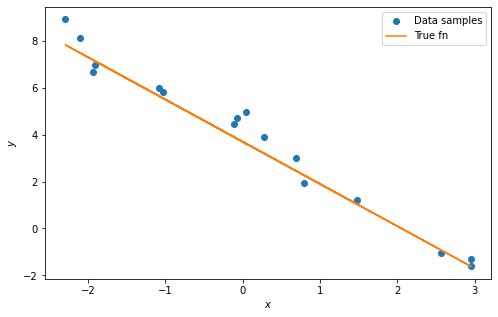

In [4]:
# Pull a batch of training data and plot it, along with the true underyling function

x_sample, y_sample = next(train_data)

plt.figure(figsize=(8, 5))
plt.scatter(x_sample, y_sample, label='Data samples')
plt.plot(x_sample, true_beta0 + x_sample * true_beta, color='C1', label='True fn')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

The loss that we wish to minimise is the expected mean squared error loss:

$$
\mathcal{L}(\beta_0, \boldsymbol\beta) := \mathbb{E}_{x, y\sim p_{data}} \left[\frac{1}{2}(y - \beta_0 - \boldsymbol x^T\boldsymbol\beta)^2\right]
$$

We first compute the mean squared error loss on a batch of input and output data.

In [5]:
## EDIT THIS FUNCTION
def mse_loss(x, y, beta0, beta):
    
    # x: K x D array of inputs
    # y: K x 1 array of outputs
    # beta0: Length 1 1-D array for bias parameter
    # beta: D x 1 array of parameters
    # returns: MSE computed on this batch of inputs and outputs; K x 1 array
    
    loss = 0.5 * ((y - beta0 - x @ beta)**2).mean() ## <-- SOLUTION
    return loss 

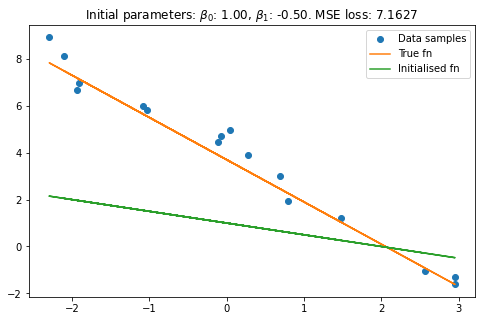

In [6]:
# Initialise the parameters and plot the initialised regression function

beta0, beta = np.array([1.0]), np.array([[-0.5]])

plt.figure(figsize=(8, 5))
plt.scatter(x_sample, y_sample, label='Data samples')
plt.plot(x_sample, true_beta0 + x_sample * true_beta, color='C1', label='True fn')
plt.plot(x_sample, beta0 + x_sample * beta, color='C2', label='Initialised fn')
plt.title(r'Initial parameters: $\beta_0$: {:.2f}, $\beta_1$: {:.2f}. MSE loss: {:.4f}'.format(
    np.squeeze(beta0), np.squeeze(beta), mse_loss(x_sample, y_sample, beta0, beta))
         )
plt.legend()
plt.show()

Stochastic gradient descent samples a batch of $K$ input and output samples, and makes a parameter update by  computing the gradient 

$$
\nabla_{(\beta_0, \boldsymbol\beta)}\mathcal{L}(\beta_0^{(i)}, \boldsymbol\beta^{(i)} \mid \mathcal{X}^{(i)}, \mathcal{Y}^{(i)}),
$$

where $\beta_0^{(i)}, \boldsymbol\beta^{(i)}$ are the values of the parameters at the $i$-th iteration of the algorithm, and $\mathcal{X}^{(i)}, \mathcal{Y}^{(i)}$ are the $i$-th batch of inputs and outputs.

The following function should compute this gradient for a given batch of data, and current parameter values.

In [7]:
## EDIT THIS FUNCTION
def grad(x, y, beta0, beta):
    
    # x: K x D array of inputs
    # y: K x 1 array of outputs
    # beta0: Length 1 1-D array for bias parameter
    # beta: D x 1 array of parameters
    # returns: tuple of gradients for beta0 (length 1 1-D array) and beta (D x 1 array)
    
    g = (y - beta0 - x @ beta)  ## <-- K x 1 array
    return -g.mean(axis=0), -(x.T[..., np.newaxis] * g).mean(axis=1)

We now have what we need to run the SGD algorithm for our problem task.

Recall that stochastic gradient descent makes the following parameter update at each iteration:

$$
(\beta_0^{(i+1)}, \boldsymbol\beta^{(i+1)}) = (\beta_0^{(i)}, \boldsymbol\beta^{(i)}) - \eta \nabla_{(\beta_0, \boldsymbol\beta)}\mathcal{L}(\beta_0^{(i)}, \boldsymbol\beta^{(i)} \mid \mathcal{X}^{(i)}, \mathcal{Y}^{(i)}),
$$

where $\eta>0$ is the learning rate.

In [26]:
# Run the SGD algorithm

iterations = 2000
losses = []
learning_rate = 0.001

for iteration in range(iterations):
    x_batch, y_batch = next(train_data)
    losses.append(mse_loss(x_batch, y_batch, beta0, beta))
    beta0_grad, beta_grad = grad(x_batch, y_batch, beta0, beta)
    beta0 -= learning_rate * beta0_grad
    beta -= learning_rate * beta_grad

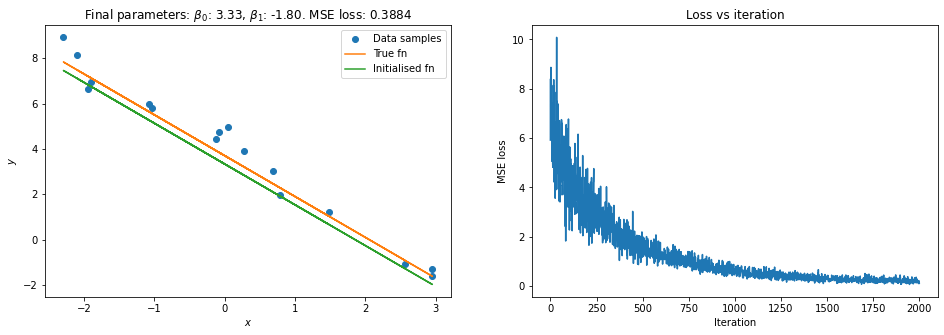

In [9]:
# Plot the learned regression function and loss values

fig = plt.figure(figsize=(16, 5))
fig.add_subplot(121)
plt.scatter(x_sample, y_sample, label='Data samples')
plt.plot(x_sample, true_beta0 + x_sample * true_beta, color='C1', label='True fn')
plt.plot(x_sample, beta0 + x_sample * beta, color='C2', label='Initialised fn')
plt.title(r'Final parameters: $\beta_0$: {:.2f}, $\beta_1$: {:.2f}. MSE loss: {:.4f}'.format(
    np.squeeze(beta0), np.squeeze(beta), mse_loss(x_sample, y_sample, beta0, beta))
         )
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()

fig.add_subplot(122)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.title("Loss vs iteration")
plt.show()

#### Questions
1. Does the solution above look reasonable?
2. Play around with different values of the learning rate. How is the convergence of the algorithm affected?
3. Try using different batch sizes and re-run the algorithm. What changes?

## 2. Multilayer Perceptron (MLP)

The MLP is a type of neural network model, that composes multiple affine transformations together, and applying a pointwise nonlinearity in between:

$$
\begin{align}
\boldsymbol{h}^{(0)} &:= \boldsymbol{x},\\
\boldsymbol{h}^{(k)} &= \sigma\left((\boldsymbol{h}^{(k-1)})^T \boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)} \right),\qquad k=1,\ldots, L,\\
\hat{\boldsymbol{y}} &= \sigma_{out}\left((\boldsymbol{h}^{(L)})^T \boldsymbol{W}^{(L)} + \boldsymbol{b}^{(L)} \right),
\end{align}
$$

where $\boldsymbol x\in\mathbb{R}^D$, $\hat{\boldsymbol{y}}\in\mathbb{R}^{n_{L+1}}$, $L$ is the number of hidden layers in the model, $\boldsymbol{W}^{(k)}\in\mathbb{R}^{n_{k}\times n_{k+1}}$, $\boldsymbol{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$, $\boldsymbol{h}^{(k)}\in\mathbb{R}^{n_k}$, $\sigma, \sigma_{out}: \mathbb{R}\mapsto\mathbb{R}$ are activation functions that operate element-wise, $n_k$ is the number of units in the $k$-th hidden layer, and we have set $n_0 := D$.

For this section of the tutorial we will use the California Housing dataset from sklearn.

In [10]:
# Load the dataset

from sklearn.datasets import fetch_california_housing

california_housing_data = fetch_california_housing()
print(california_housing_data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [11]:
# Create training and test splits

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(california_housing_data.data, 
                                                    california_housing_data.target,
                                                    test_size=0.2)

In [12]:
# Standardise the inputs

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Now you should implement an MLP regression model in numpy. The model will have three hidden layers with 64 neurons each, and using a ReLU activation function. The final output layer will be a single neuron with no activation function to predict the target variable $y$.

The building block of the model is the dense (or fully-connected) layer. The following function should implement the affine transformation of this layer, given kernel and bias parameters and the input to the layer. It should return the layer pre-activations (no activation function).

In [13]:
## EDIT THIS FUNCTION
def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b + x @ W  ## <-- pre-activations
    return h

The hidden layers of our model will use a ReLU activation function. You should implement that in the following function.

In [14]:
## EDIT THIS FUNCTION
def relu(h):
    
    # h: K x h_out array of pre-activations
    # returns: K x h_out output array 
    
    h = np.maximum(h, 0.)  ## <-- post-activations
    return h

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{8\times 64}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{64}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{64\times 64}$, $k=1, 2$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{64}$, $k=1, 2$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(3)} \in\mathbb{R}^{64\times 1}$
* Bias $\boldsymbol{b}^{(3)} \in\mathbb{R}^{1}$

We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as [Glorot initialisation](http://proceedings.mlr.press/v9/glorot10a.html). The bias parameters will be initialised to zeros.

In [15]:
# Create the parameters

var0 = 2. / (64 + 8)
W0 = np.random.randn(8, 64) * np.sqrt(var0)
b0 = np.zeros(64)

var1 = 2. / (64 + 64)
W1 = np.random.randn(64, 64) * np.sqrt(var1)
b1 = np.zeros(64)

var2 = 2. / (64 + 64)
W2 = np.random.randn(64, 64) * np.sqrt(var2)
b2 = np.zeros(64)

var3 = 2. / (1 + 64)
W3 = np.random.randn(64, 1) * np.sqrt(var3)
b3 = np.zeros(1)

You should use these parameters and your `dense` function to create the MLP model. Remember that the hidden layers of the model should use a ReLU activation, and the output of the model should not use an activation function.

In [16]:
## EDIT THIS FUNCTION
def mlp(x):
    
    # x: K x 8 array of inputs
    # returns: K x 1 output array 
    
    h = dense(x, W0, b0)
    h = relu(h)
    h = dense(h, W1, b1)
    h = relu(h)
    h = dense(h, W2, b2)
    h = relu(h)
    y = dense(h, W3, b3)
    return y

In [17]:
# Get the output of your initialised model

y_hat_test = mlp(x_test)

Now we will implement the MLP in TensorFlow and train it on the dataset. The following function should build the same MLP model in TensorFlow, and set the parameter values to the same as you have used in the numpy implementation above.

In [18]:
## EDIT THIS FUNCTION
def get_model():
    
    # This function should create the MLP and set its parameters to the same as above
    # returns: TensorFlow Sequential model object
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(8,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.layers[0].kernel.assign(W0)
    model.layers[0].bias.assign(b0)
    
    model.layers[1].kernel.assign(W1)
    model.layers[1].bias.assign(b1)
    
    model.layers[2].kernel.assign(W2)
    model.layers[2].bias.assign(b2)
    
    model.layers[3].kernel.assign(W3)
    model.layers[3].bias.assign(b3)
    return model

In [19]:
# Run your function to get the TensorFlow MLP model

model = get_model()

In [20]:
# Check the output is the same as for your numpy implementation

tf_y_hat_test = model(x_test).numpy()
np.allclose(tf_y_hat_test, y_hat_test, atol=1e-4)

True

We will now train the TensorFlow MLP model. First, you should create Dataset objects for the training and test sets. 

* The Datasets should return a tuple of inputs and outputs
* The training Dataset should be shuffled (use a buffer size of 1024)
* Both Datasets should be batched (use a batch size of 64)

In [21]:
## EDIT THIS FUNCTION
def get_datasets():
    
    # returns: A tuple of tf.data.Dataset objects for train and test sets
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    
    train_dataset = train_dataset.shuffle(1024)
    
    train_dataset = train_dataset.batch(64)
    test_dataset = test_dataset.batch(64)
    
    return train_dataset, test_dataset

In [22]:
# Run your function to get the Datasets

train_dataset, test_dataset = get_datasets()

We are now ready to compile and train our model.

In [23]:
# Compile and fit the model

model.compile(optimizer='sgd', loss='mse')
history = model.fit(train_dataset, epochs=100, verbose=0)

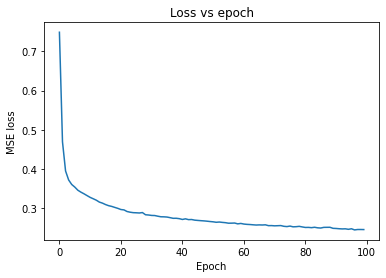

In [24]:
# Plot the loss vs epoch

plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Loss vs epoch")
plt.show()

In [25]:
# Evaluate on the test Dataset

model.evaluate(test_dataset)

65/65 [==============================] - 0s 668us/step - loss: 0.2732


0.2732473909854889

#### Questions
1. How do the training and test losses above compare?
2. Play around with different numbers of hidden layers and number of neurons in the MLP. How is the performance of the model affected?